<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_End_to_End_Multi_Day_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import joblib
import pickle
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Working Directory 
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'

# Prepare Data

## Read Data

In [3]:
import scipy.io
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'
# fall, winter, spring, summer
filenames =['colloc_Precipflag_DPR_GMI_20151007.sav',
            'colloc_Precipflag_DPR_GMI_20160113.sav',
            'colloc_Precipflag_DPR_GMI_20160401.sav']
            #,'colloc_Precipflag_DPR_GMI_20170606.sav']
FILE_PATHS = [BASE_DIR + fn for fn in filenames]
data = [scipy.io.readsav(filepath, verbose=1) for filepath in FILE_PATHS]

--------------------------------------------------
Date: Sat Jun 27 00:49:52 2020
User: jgong
Host: gs613-cirrus.ndc.nasa.gov
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.3
--------------------------------------------------
Successfully read 14 records of which:
 - 11 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - tc [<class 'numpy.ndarray'>]
 - latc [<class 'numpy.ndarray'>]
 - lonc [<class 'numpy.ndarray'>]
 - utc [<class 'numpy.ndarray'>]
 - emis [<class 'numpy.ndarray'>]
 - emis_std [<class 'numpy.ndarray'>]
 - ts [<class 'numpy.ndarray'>]
 - clwp [<class 'numpy.ndarray'>]
 - twv [<class 'numpy.ndarray'>]
 - tysfc [<class 'numpy.ndarray'>]
 - pflag [<class 'numpy.ndarray'>]
--------------------------------------------------
--------------------------------------------------
Date: Fri Jun 26 15:53:36 2020


## Trim Data

In [4]:
import copy
data_trimmed = []
for i, data_i in enumerate(data):
  data_trimmed_i = {}
  for var, arr in data_i.items():
    if arr.ndim == 1:
      data_trimmed_i[var] = arr[1:] 
    else:
      data_trimmed_i[var] = arr[1:, 25:196] if arr.ndim == 2 else arr[1:, 25:196, :] 

  for var, arr in data_trimmed_i.items():
    print(f"{var}: {arr.shape}")
  print('-' * 15)
  data_trimmed.append(data_trimmed_i)

# free up memory
del data

tc: (47380, 171, 13)
latc: (47380, 171)
lonc: (47380, 171)
utc: (47380,)
emis: (47380, 171, 13)
emis_std: (47380, 171, 13)
ts: (47380, 171)
clwp: (47380, 171)
twv: (47380, 171)
tysfc: (47380, 171)
pflag: (47380, 171)
---------------
tc: (47370, 171, 13)
latc: (47370, 171)
lonc: (47370, 171)
utc: (47370,)
emis: (47370, 171, 13)
emis_std: (47370, 171, 13)
ts: (47370, 171)
clwp: (47370, 171)
twv: (47370, 171)
tysfc: (47370, 171)
pflag: (47370, 171)
---------------
tc: (47407, 171, 13)
latc: (47407, 171)
lonc: (47407, 171)
utc: (47407,)
emis: (47407, 171, 13)
emis_std: (47407, 171, 13)
ts: (47407, 171)
clwp: (47407, 171)
twv: (47407, 171)
tysfc: (47407, 171)
pflag: (47407, 171)
---------------


## Polarization Differences (PDs)

In [5]:
# calculate polarization differences (PD)
def add_to_PD_i(i, freq, ind1, ind2, data):
  PD[i][freq] = data[i]['tc'][:, :, ind1] - data[i]['tc'][:, :, ind2]

PD = [{} for _ in range(len(data_trimmed))]
for i in range(len(data_trimmed)):
  add_to_PD_i(i, '10.65', 0, 1, data_trimmed)
  add_to_PD_i(i, '18.70', 2, 3, data_trimmed)
  add_to_PD_i(i, '36.50', 5, 6, data_trimmed)
  add_to_PD_i(i, '89.00', 7, 8, data_trimmed)
  add_to_PD_i(i, '166.0', 9, 10, data_trimmed)
  print(PD[i].keys())

dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])
dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])
dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])


## Construct DataFrame

In [6]:
# ravel 2d data --> scans one after another
'''
* 13 channels TB
* 3 channels PD (10.65, 89 and 166 GHz)
x Surface emissivity
* Ts
* CLWP
* TWV
* Lat/Lon
- Day of the year starting from the first day of the year (i.e., Julian day. For example, 1/1/2017 is 1, 2/1/2017 is 32)
'''
data_dfs = []

PD_freqs_append = ['10.65', '89.00', '166.0']
data_2d = {'latc': 'lat',
           'lonc': 'lon',
           'ts': 'ts',
           'clwp': 'clwp',
           'twv': 'twv'}
for i, data_i in enumerate(data_trimmed):
  curr_df = pd.DataFrame()
  # 2d data
  for data_name, df_name in data_2d.items():
    curr_df[df_name] = np.ravel(data_i[data_name])

  # PDs
  for freq in PD_freqs_append:
    curr_df[f'PD_{freq}'] = np.ravel(PD[i][freq])

  # 3d data
  for idx in range(data_i['tc'].shape[2]):
    curr_df[f'tc_{idx}'] = np.ravel(data_i['tc'][:, :, idx])

  data_dfs.append(curr_df)
  del curr_df

print('combining DataFrames')
data_df = pd.concat(data_dfs, ignore_index = True)
del data_dfs
data_df.head()

combining DataFrames


,lat,lon,ts,clwp,twv,PD_10.65,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
0,-68.794342,121.109978,-99.0,-99.0,-99.0,22.889999,14.330002,10.839996,228.770004,205.880005,223.490005,204.559998,222.809998,224.610001,208.850006,231.000000,216.669998,227.389999,216.550003,237.830002,230.470001
1,-68.736092,121.270271,-99.0,-99.0,-99.0,24.899994,13.979996,12.560013,229.369995,204.470001,222.880005,203.619995,223.070007,224.199997,208.869995,230.679993,216.699997,228.960007,216.399994,237.610001,231.130005
2,-68.716942,121.389320,-99.0,-99.0,-99.0,24.840012,14.509995,9.139999,228.990005,204.149994,223.880005,203.710007,223.369995,224.240005,208.160004,231.479996,216.970001,227.419998,218.279999,238.160004,231.839996
3,-68.697197,121.507530,-99.0,-99.0,-99.0,25.550003,14.410004,10.429993,228.979996,203.429993,223.240005,202.210007,222.839996,224.020004,205.979996,231.139999,216.729996,226.339996,215.910004,237.490005,231.080002
4,-68.648026,121.535782,-99.0,-99.0,-99.0,24.010010,14.319992,10.379990,228.630005,204.619995,223.919998,202.509995,222.520004,223.520004,206.960007,230.789993,216.470001,228.259995,217.880005,238.449997,231.389999


In [7]:
y = pd.DataFrame()
y['pflag'] = np.concatenate(tuple(np.ravel(data_trimmed[i]['pflag']).byteswap().newbyteorder() for i in range(len(data_trimmed))))
y.head()

,pflag
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


## Drop Unwanted

In [8]:
X_dropped = data_df[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
X_dropped.head()

,lat,lon,ts,clwp,twv,PD_10.65,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
405,-65.898605,125.724609,258.322540,0.011064,2.236660,29.500000,15.860001,7.970001,255.880005,226.380005,246.889999,221.880005,246.110001,244.300003,222.809998,235.240005,219.380005,229.220001,221.250000,246.289993,242.410004
406,-65.805023,125.751350,258.579742,0.014423,2.670216,29.080002,16.639999,8.400009,253.389999,224.309998,242.050003,215.660004,239.710007,241.649994,220.169998,236.690002,220.050003,230.100006,221.699997,246.559998,244.940002
407,-65.758141,125.762604,258.836304,0.017788,2.518587,30.960007,17.520004,9.369995,252.440002,221.479996,237.250000,211.589996,237.020004,238.259995,216.669998,236.710007,219.190002,231.639999,222.270004,246.270004,244.490005
408,-65.711205,125.772438,259.092346,0.021157,2.816634,31.970001,17.740005,8.839996,251.350006,219.380005,237.149994,211.309998,236.559998,239.070007,218.169998,236.779999,219.039993,232.750000,223.910004,245.880005,245.850006
409,-65.664230,125.780869,259.347931,0.024527,2.969014,28.739990,18.130005,9.139999,248.699997,219.960007,238.360001,211.179993,237.539993,239.399994,217.750000,238.830002,220.699997,234.940002,225.800003,245.990005,247.029999


In [9]:
print(y.shape)
y_dropped = y[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
print(y_dropped.shape)

(24308847, 1)
(2185776, 1)


In [10]:
del data_df
del y

## Scale (Numerical) & One-Hot Encode (Categorical) Data

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_prep = scaler.fit_transform(X_dropped)
X_prep.shape

(2185776, 21)

In [12]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_prep = ohe.fit_transform(y_dropped).toarray()
y_prep.shape

(2185776, 4)

In [13]:
del X_dropped
del y_dropped

In [14]:
# should be all zeros
print("X: ", sum(np.isnan(X_prep)))
print("y: ", sum(np.isnan(y_prep)))

X:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y:  [0 0 0 0]


## Save Data

In [15]:
with open(BASE_DIR + 'X_data_3_days.pkl', 'wb') as f:
  pickle.dump(X_prep, f)
  del X_prep

with open(BASE_DIR + 'y_data_3_days.pkl', 'wb') as f:
  pickle.dump(y_prep, f)
  del y_prep

# Load and Split Data

In [16]:
with open(BASE_DIR + 'X_data_3_days.pkl', 'rb') as f:
  X = pickle.load(f)
  print(f'Loaded X. {X.shape}')

with open(BASE_DIR + 'y_data_3_days.pkl', 'rb') as f:
  y = pickle.load(f)
  print(f'Loaded y. {y.shape}')

Loaded X. (2185776, 21)
Loaded y. (2185776, 4)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y
print(f"train: {X_train.shape} {y_train.shape}")
print(f"test: {X_test.shape} {y_test.shape}")

train: (1748620, 21) (1748620, 4)
test: (437156, 21) (437156, 4)


# Under Sampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler

rus_dict = {0: 45000}
rus = RandomUnderSampler(rus_dict, random_state=42)
X_res, y_res = rus.fit_sample(X_train, y_train)
print(X_res.shape, y_res.shape)

(98857, 21) (98857, 4)


In [19]:
from collections import Counter
print("original: ", Counter(np.argmax(y_train, axis=1)))
print("SMOTE: ", Counter(np.argmax(y_res, axis=1)))

original:  Counter({0: 1694763, 1: 46205, 3: 3961, 2: 3691})
SMOTE:  Counter({1: 46205, 0: 45000, 3: 3961, 2: 3691})


# XGBoost

In [20]:
# # Random Forest Hyperparameters
# n_estimators = 150
# max_depth = 15
# bootstrap = True
# criterion = 'entropy'
# class_weight = 'balanced_subsample'
# random_state = 42
# n_job = -1

In [21]:
xgb = XGBClassifier()

xgb.fit(X_res, np.argmax(y_res, axis=1))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Save and Load Model

In [22]:
# save trained model
joblib.dump(xgb, BASE_DIR + 'xgboost_with_class_weights_3_days.model')

['/content/drive/My Drive/data/NASA_2020/xgboost_with_class_weights_3_days.model']

In [23]:
# load existing model
xgb = joblib.load(BASE_DIR + 'xgboost_with_class_weights_3_days.model')

In [24]:
y_pred = xgb.predict(X_test)

In [25]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [33]:
y_probs = xgb.predict_proba(X_test)
y_probs

array([[8.5829055e-01, 1.1629513e-01, 1.8623263e-02, 6.7911134e-03],
       [1.6773887e-01, 7.2053754e-01, 3.1853057e-02, 7.9870559e-02],
       [8.3301389e-01, 1.3742475e-01, 5.3390041e-03, 2.4222339e-02],
       ...,
       [9.7251159e-01, 2.1367788e-02, 1.3597589e-03, 4.7608847e-03],
       [9.9151492e-01, 5.9035476e-03, 7.2947686e-04, 1.8520129e-03],
       [9.6984148e-01, 1.9819867e-02, 2.6603397e-03, 7.6783351e-03]],
      dtype=float32)

In [32]:
print(y_probs[0][:, 1])
print(y_probs[1][:, 1])
print(y_probs[2][:, 1])
print(y_probs[3][:, 1])
print("-"*30)
y_pred_probs = np.transpose(np.array([y_probs[0][:, 1], y_probs[1][:, 1], y_probs[2][:, 1], y_probs[3][:, 1]]))
print(y_pred_probs)

IndexError: ignored

## Confusion Matrix

In [28]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

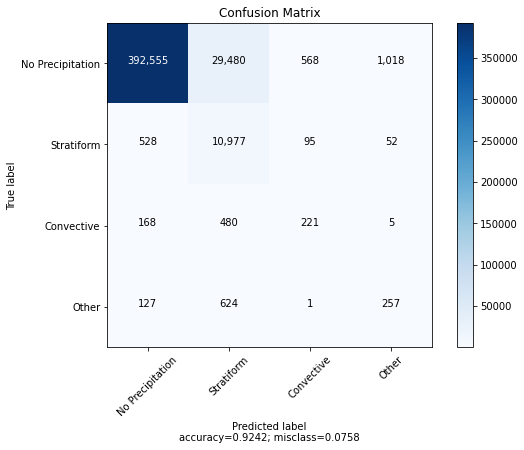

In [29]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['No Precipitation', 'Stratiform', 'Convective', 'Other'],
                      title        = "Confusion Matrix")

## ROC Curves

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, y_true, y_pred):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = y_true[:, i]
            pred = y_pred[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

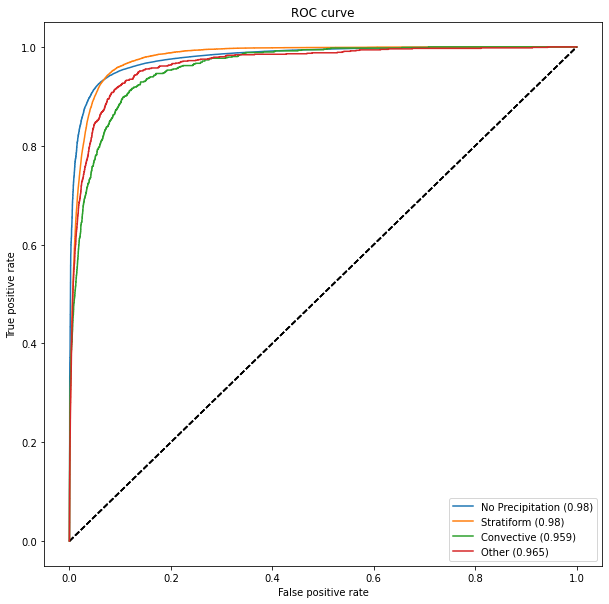

In [36]:
auc_rocs = get_roc_curve(['No Precipitation', 'Stratiform', 'Convective', 'Other'], y_test, y_probs)

21


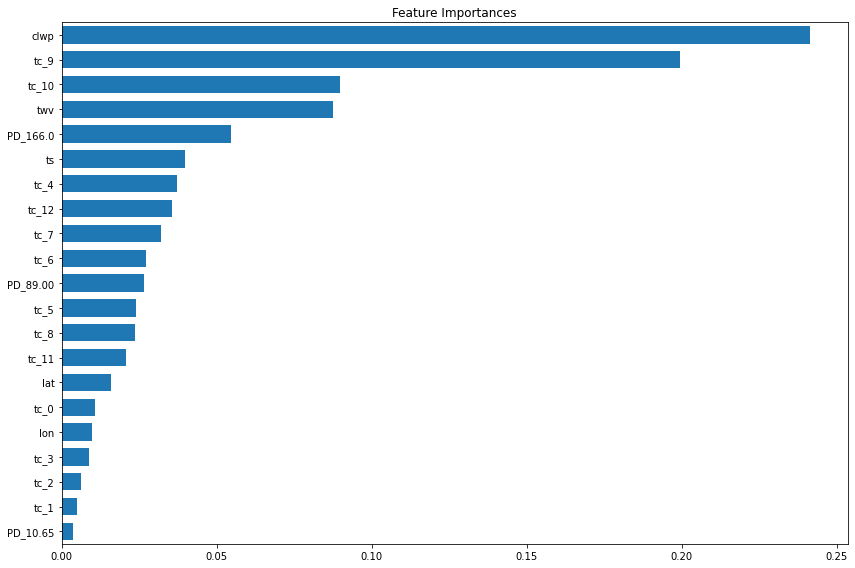

In [37]:
feature_names = np.array(['lat', 'lon',	'ts',	'clwp',	'twv', 'PD_10.65',	'PD_89.00',	'PD_166.0', 'tc_0', 'tc_1',	'tc_2', 'tc_3', 'tc_4',	'tc_5',	'tc_6',	'tc_7',	'tc_8',	'tc_9',	'tc_10', 'tc_11', 'tc_12'])
print(len(feature_names))
tree_importance_sorted_idx = np.argsort(xgb.feature_importances_)
tree_indices = np.arange(0, len(xgb.feature_importances_)) + 0.5
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices,
         xgb.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(xgb.feature_importances_)))
plt.title('Feature Importances')
fig.tight_layout()
plt.show()

# Make Predictions (Squall Line case)

In [ ]:
FILE_PATH = BASE_DIR + 'colloc_Precipflag_DPR_GMI_20170606.sav'
data = scipy.io.readsav(FILE_PATH, verbose=1)
for var, arr in data.items():
  print(f"{var}: {arr.shape}")

In [ ]:
# calculate polarization differences (PD)
def add_to_PD(freq, ind1, ind2, data):
  PD[freq] = data['tc'][:, :, ind1] - data['tc'][:, :, ind2]

PD = {}
add_to_PD('10.65', 0, 1, data)
add_to_PD('18.70', 2, 3, data)
add_to_PD('36.50', 5, 6, data)
add_to_PD('89.00', 7, 8, data)
add_to_PD('166.0', 9, 10, data)
print(PD.keys())

In [ ]:
def create_pred_df(lat_bounds, lon_bounds, epsilon=0.0):
  col_names = ['lat', 'lon', 'ts', 'clwp', 'twv', 'PD_10.65', 'PD_89.00', 'PD_166.0'] + [f'tc_{i}' for i in range(data['tc'].shape[2])]
  data_df = pd.DataFrame(columns=col_names)
  y_df = pd.DataFrame(columns=['pflag'])
  counter = 0
  for idx in np.ndindex(data['latc'].shape):
    if (lat_bounds[0] - epsilon <= data['latc'][idx] <= lat_bounds[1] + epsilon) and (lon_bounds[0] - epsilon <= data['lonc'][idx] <= lon_bounds[1] + epsilon):
      data_dict = {}
      data_dict['lat'] = data['latc'][idx]
      data_dict['lon'] = data['lonc'][idx]
      data_dict['ts'] = data['ts'][idx]
      data_dict['clwp'] = data['clwp'][idx]
      data_dict['twv'] = data['twv'][idx]
      data_dict['PD_10.65'] = PD['10.65'][idx]
      data_dict['PD_89.00'] = PD['89.00'][idx]
      data_dict['PD_166.0'] = PD['166.0'][idx]

      for i in range(data['tc'].shape[2]):
        data_dict[f'tc_{i}'] = data['tc'][idx][i]
      
      data_df = data_df.append(data_dict, ignore_index=True)
      y_df = y_df.append({'pflag': data['pflag'][idx]}, ignore_index=True)
      counter += 1
  print(counter)
  return data_df, y_df

In [ ]:
latitude_bounds = [14.2, 18.0]
longitude_bounds = [-5.0, -2.1]

In [ ]:
X_df, y_df = create_pred_df(latitude_bounds, longitude_bounds, epsilon=5.0)
del data

In [ ]:
print(X_df.shape)
print(y_df.shape)
y_df = y_df[(~np.isnan(X_df['twv']))]
X_df = X_df[(~np.isnan(X_df['twv']))]

In [ ]:
X_df.head()

In [ ]:
y_df.head()

In [ ]:
lat, lon, counts = [], [], []
rfc.verbose = False
X_scaled = scaler.transform(X_df)
print("X: ", sum(np.isnan(X_scaled)))  # should be all zeros
y_pred = np.argmax(rfc.predict(X_scaled), axis=1)

row_set = set()
for r, _ in np.ndindex(X_scaled.shape):
  if r in row_set:
    continue
  row_set.add(r)
  lat.append(X_df.iloc[r, 0])
  lon.append(X_df.iloc[r, 1])

  y_val = y_df.iloc[r, 0]
  if np.isnan(y_val):
    counts.append(y_pred[r].astype(float))
  else:
    counts.append(y_val)

In [ ]:
print(len(lat))
print(len(lon))
print(len(counts))

In [ ]:
title = "Precip. Type Filled"
plt.scatter(lon, lat, c=counts, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.title(title)
### SAVE HEATMAP ###############################
save_path = BASE_DIR + "plots/"
if not os.path.exists(save_path):
  os.mkdir(save_path)
print('Saved to', save_path + f"{title}.png")
plt.savefig(save_path + f"{title}.png")
################################################
plt.show()